In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import kr_helper_funcs as kr
from sklearn.preprocessing import MinMaxScaler
import kr_helper_funcs as kr
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from lime import lime_tabular
import shap
import tensorflow_addons as tfa
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [124]:
name = 'without_postcode'
fileName = "{}/lending-club-values.csv".format(name)

radam = tfa.optimizers.RectifiedAdam()
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
model = tf.keras.models.load_model('{}/lending-club.h5'.format(name), custom_objects={"f1": kr.f1, "optimizer": ranger})
X_train_unscaled = np.load("{}/X_train_unscaled.npy".format(name))
X_test_unscaled = np.load("{}/X_test_unscaled.npy".format(name))
y_train = np.load("{}/y_test.npy".format(name))
y_test = np.load("{}/y_test.npy".format(name))
df = pd.read_csv('{}/lending-club-df.csv'.format(name))
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

prev_scaled_row = None
cached_map_values = None
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

res = pd.read_csv(fileName)

In [3]:
res

,original_probability,new_probability,confidence_diff,original_class,class_change,no_features,nsamples,explainer,time,feature_rankings,...,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10
0,0.531096,0.531096,0.000000e+00,1,False,0,100,shap,2.794693,first,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.531096,0.531096,5.960464e-08,1,False,0,100,shap,0.616999,first,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.531096,0.531096,0.000000e+00,1,False,0,100,shap,0.153088,middle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.531096,0.531096,5.960464e-08,1,False,0,100,shap,0.607831,middle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.531096,0.531096,0.000000e+00,1,False,0,100,shap,0.158313,last,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107707,0.692507,0.730657,-3.814942e-02,1,False,9,auto,random,2.789584,middle,...,10.0,4.0,14.0,5.0,2.0,18.0,1.0,3.0,NaN,NaN
107708,0.692507,0.574869,1.176388e-01,1,False,9,auto,random,2.925323,last,...,18.0,1.0,3.0,9.0,11.0,8.0,0.0,16.0,NaN,NaN
107709,0.692507,0.627073,6.543457e-02,1,False,10,auto,random,2.807856,first,...,12.0,6.0,17.0,15.0,7.0,10.0,4.0,14.0,5.0,NaN
107710,0.692507,0.688427,4.080653e-03,1,False,10,auto,random,3.111922,middle,...,7.0,10.0,4.0,14.0,5.0,2.0,18.0,1.0,3.0,NaN


In [4]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'loan_repaid', 'earliest_cr_year'],
      dtype='object')

In [5]:
df.corr()["loan_amnt"].sort_values(ascending=False)

loan_amnt               1.000000
installment             0.953872
term                    0.393731
annual_inc              0.337364
revol_bal               0.328515
verification_status     0.300254
mort_acc                0.223992
total_acc               0.223695
open_acc                0.198347
sub_grade               0.181900
home_ownership          0.174550
int_rate                0.168599
revol_util              0.099581
application_type        0.022359
dti                     0.016338
loan_repaid            -0.059731
initial_list_status    -0.077159
pub_rec                -0.078143
pub_rec_bankruptcies   -0.106669
earliest_cr_year       -0.147380
Name: loan_amnt, dtype: float64

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[0.6489159464836121, 0.6362425088882446, 0.6338264346122742, 0.6318450570106506, 0.6300534605979919, 0.6296069025993347, 0.6284545660018921, 0.6278125047683716, 0.6273818016052246, 0.6265324354171753, 0.626384437084198, 0.6258149147033691, 0.6249619126319885, 0.6253494620323181, 0.6241974234580994, 0.6241049766540527]


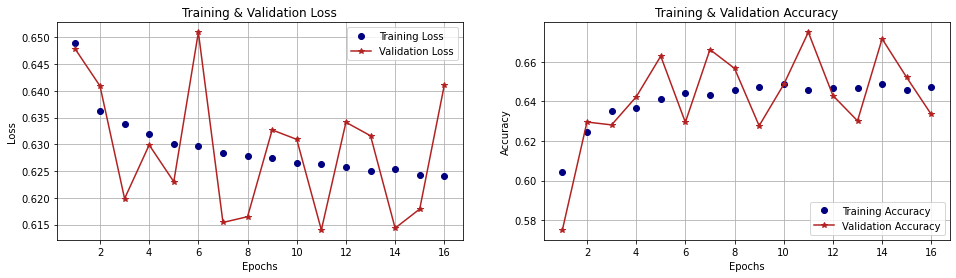

In [6]:
history = pd.read_csv('{}/lending-club-history.csv'.format(name))
history_dict = history.to_dict('list')
kr.show_plots(history_dict)

In [7]:
predictions = model.predict_classes(X_test)
print(classification_report(y_test, predictions))


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.33      0.62      0.43     15658
           1       0.88      0.69      0.77     63386

    accuracy                           0.67     79044
   macro avg       0.60      0.65      0.60     79044
weighted avg       0.77      0.67      0.70     79044



79044

In [166]:
zero_indices_correctly_predicted[0:200].extend(one_indices_correctly_predicted[0:200])
print(len(zero_indices_correctly_predicted))

400


In [170]:
predictions = model.predict_classes(X_test)
predictions_flat = [item for sublist in predictions for item in sublist]
equal_indices= predictions_flat==y_test
zero_indices = np.array(np.where(y_test==0))
zero_indices_correctly_predicted = [index for index in zero_indices[0] if equal_indices[index] ==True]

one_indices = np.array(np.where(y_test==1))
one_indices_correctly_predicted = [index for index in one_indices[0] if equal_indices[index] ==True]
print("Correctly predicted zeros: {}".format(len(zero_indices_correctly_predicted)))
print("Correctly predicted one: {}".format(len(one_indices_correctly_predicted)))

result = (zero_indices_correctly_predicted[0:200]).extend(one_indices_correctly_predicted[0:100])

indices0 = list(zero_indices_correctly_predicted[0:200])
indices1 = list(one_indices_correctly_predicted[0:200])
indices1.extend(indices0)
print(len(indices1))

Correctly predicted zeros: 6981
Correctly predicted one: 51846
400


[[ 6981  8677]
 [11540 51846]]


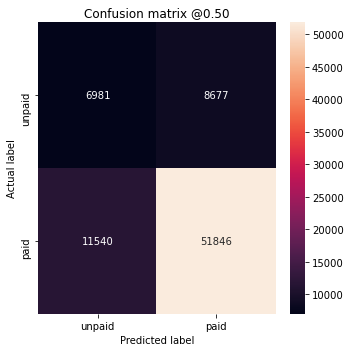

In [128]:
kr.plot_cm(y_test, predictions, ["unpaid", "paid"])

(20.0, 0.0)

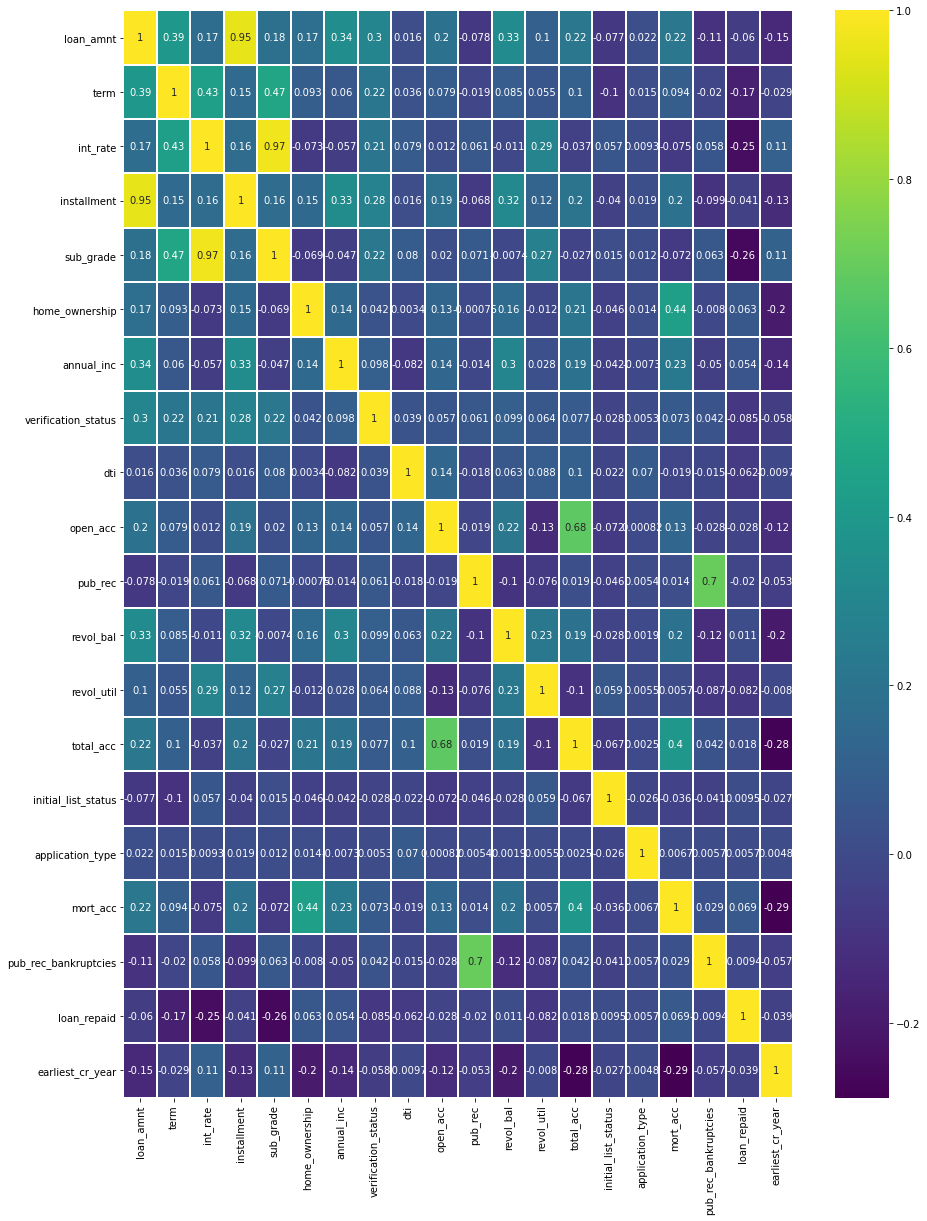

In [9]:
plt.figure(figsize=(15,20))
sns.heatmap(df.corr(),annot=True,cmap='viridis', linewidth=1)
plt.ylim(20, 0)


              precision    recall  f1-score   support

           0       0.33      0.62      0.43     15658
           1       0.88      0.69      0.77     63386

    accuracy                           0.67     79044
   macro avg       0.60      0.65      0.60     79044
weighted avg       0.77      0.67      0.70     79044



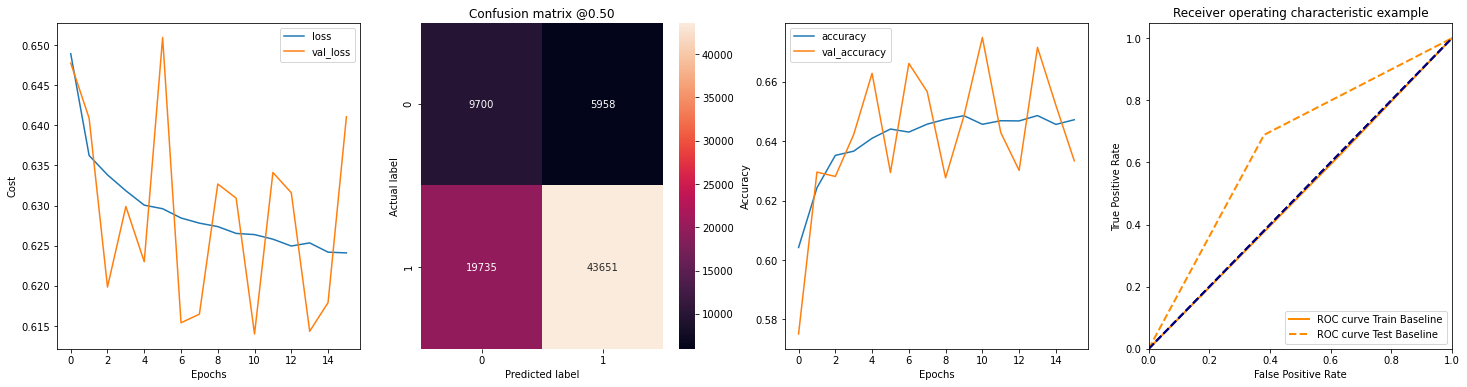

In [10]:
def plot_roc(name, labels, predictions, ax, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    lw = 2
    plt.plot(fp, tp, color='darkorange',
             lw=lw, label='ROC curve '+ name, **kwargs)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    
def plot_model_results(model):
    fig, (f1, f2, f3, f4) =plt.subplots(1,4, figsize=(25,6))
    predictions = model.predict_classes(X_test)
    report = classification_report(y_test,predictions)
    print(report)
    report_json = classification_report(y_test,predictions, output_dict=True)
#     save_report_to_latex(model_name, report_json)
    
    
    losses = pd.DataFrame(history)
    fig1 = losses[['loss','val_loss']].plot(ax=f1) 
    fig1.set_ylabel('Cost')
    fig1.set_xlabel('Epochs')
    
    cm = confusion_matrix(y_test,predictions > 0.5)
    fig2= sns.heatmap(cm, annot=True, fmt="d", ax=f2)
    fig2.set_title('Confusion matrix @{:.2f}'.format(0.5))
    fig2.set_ylabel('Actual label')
    fig2.set_xlabel('Predicted label')
    fig2.set_ylim(2, 0)

    fig3 = plot_roc("Train Baseline",y_train, model.predict_classes(X_train[:len(X_test)]) , ax=f4)
    fig3 = plot_roc("Test Baseline", y_test, model.predict_classes(X_test), ax=f4, linestyle='--')
    
    fig4 = losses[['accuracy','val_accuracy']].plot(ax=f3) 
    fig4.set_ylabel('Accuracy')
    fig4.set_xlabel('Epochs')
#     save('/building_ann/' + model_name + '.png')
    plt.show()
plot_model_results(model)

In [11]:
len(X_test)

79044

In [12]:
res[(res['nsamples'] == 'auto') & (res['explainer'] == 'random')].head()


,original_probability,new_probability,confidence_diff,original_class,class_change,no_features,nsamples,explainer,time,feature_rankings,...,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10
53856,0.531096,0.531096,0.000000e+00,1,False,0,auto,random,0.239360,first,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53857,0.531096,0.531096,5.960464e-08,1,False,0,auto,random,1.005310,first,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53858,0.531096,0.531096,0.000000e+00,1,False,0,auto,random,0.239363,middle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53859,0.531096,0.531096,5.960464e-08,1,False,0,auto,random,1.128977,middle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53860,0.531096,0.531096,0.000000e+00,1,False,0,auto,random,0.317174,last,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, "Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

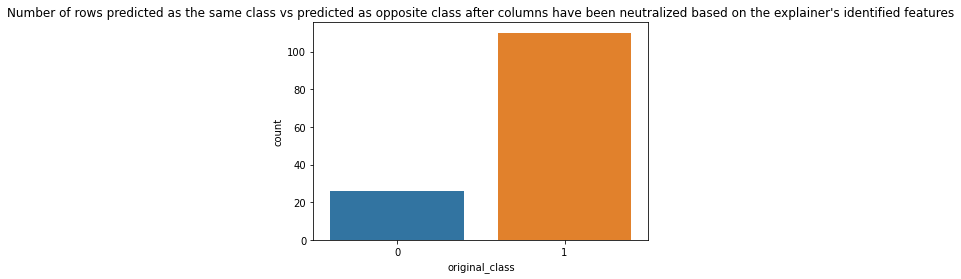

In [57]:
# no_features	nsamples	explainer	time	feature_rankings	strategy	i0	i1	i2	i3	i4	i5	i6	i7	i8	i9	i10
sns.countplot(x="original_class",data=res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution') & (res['explainer'] == 'eli5') 
                                          & (res['explainer'] == 'eli5') & (res['feature_rankings'] == 'first')  & (res['no_features'] == 0)])
plt.title("Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

Text(0.5, 1.0, "Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

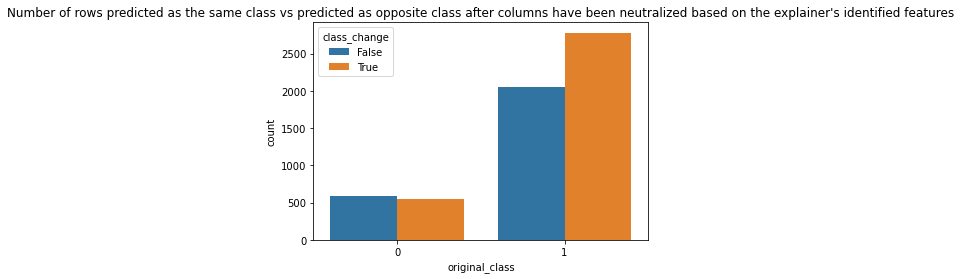

In [64]:
sns.countplot(x="original_class",data=res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution') & (res['feature_rankings'] == 'first') ], hue = 'class_change')
plt.title("Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

Text(0.5, 1.0, "Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

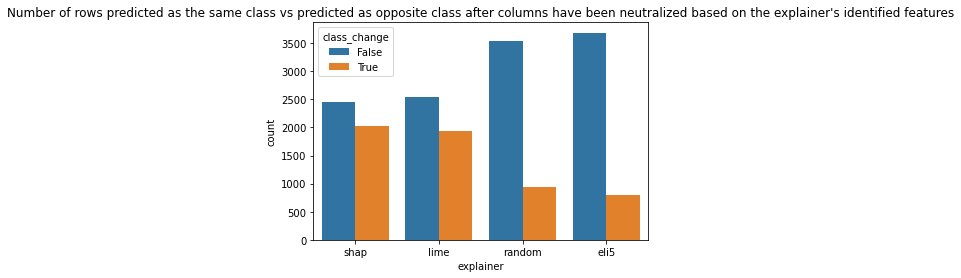

In [59]:
sns.countplot(x="explainer",data=res[(res['nsamples'] == 'auto') & (res['strategy'] == 'distribution') ], hue = 'class_change')
plt.title("Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

In [14]:
res.count()

original_probability    107712
new_probability         107712
confidence_diff         107712
original_class          107712
class_change            107712
no_features             107712
nsamples                107712
explainer               107712
time                    107712
feature_rankings        107712
strategy                107712
i0                       97920
i1                       86913
i2                       76740
i3                       66843
i4                       57012
i5                       46209
i6                       36246
i7                       26229
i8                       15810
i9                        6975
i10                          0
dtype: int64

In [15]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'loan_repaid', 'earliest_cr_year'],
      dtype='object')

Text(0.5, 1.0, 'Random - Contplot across all feature importances')

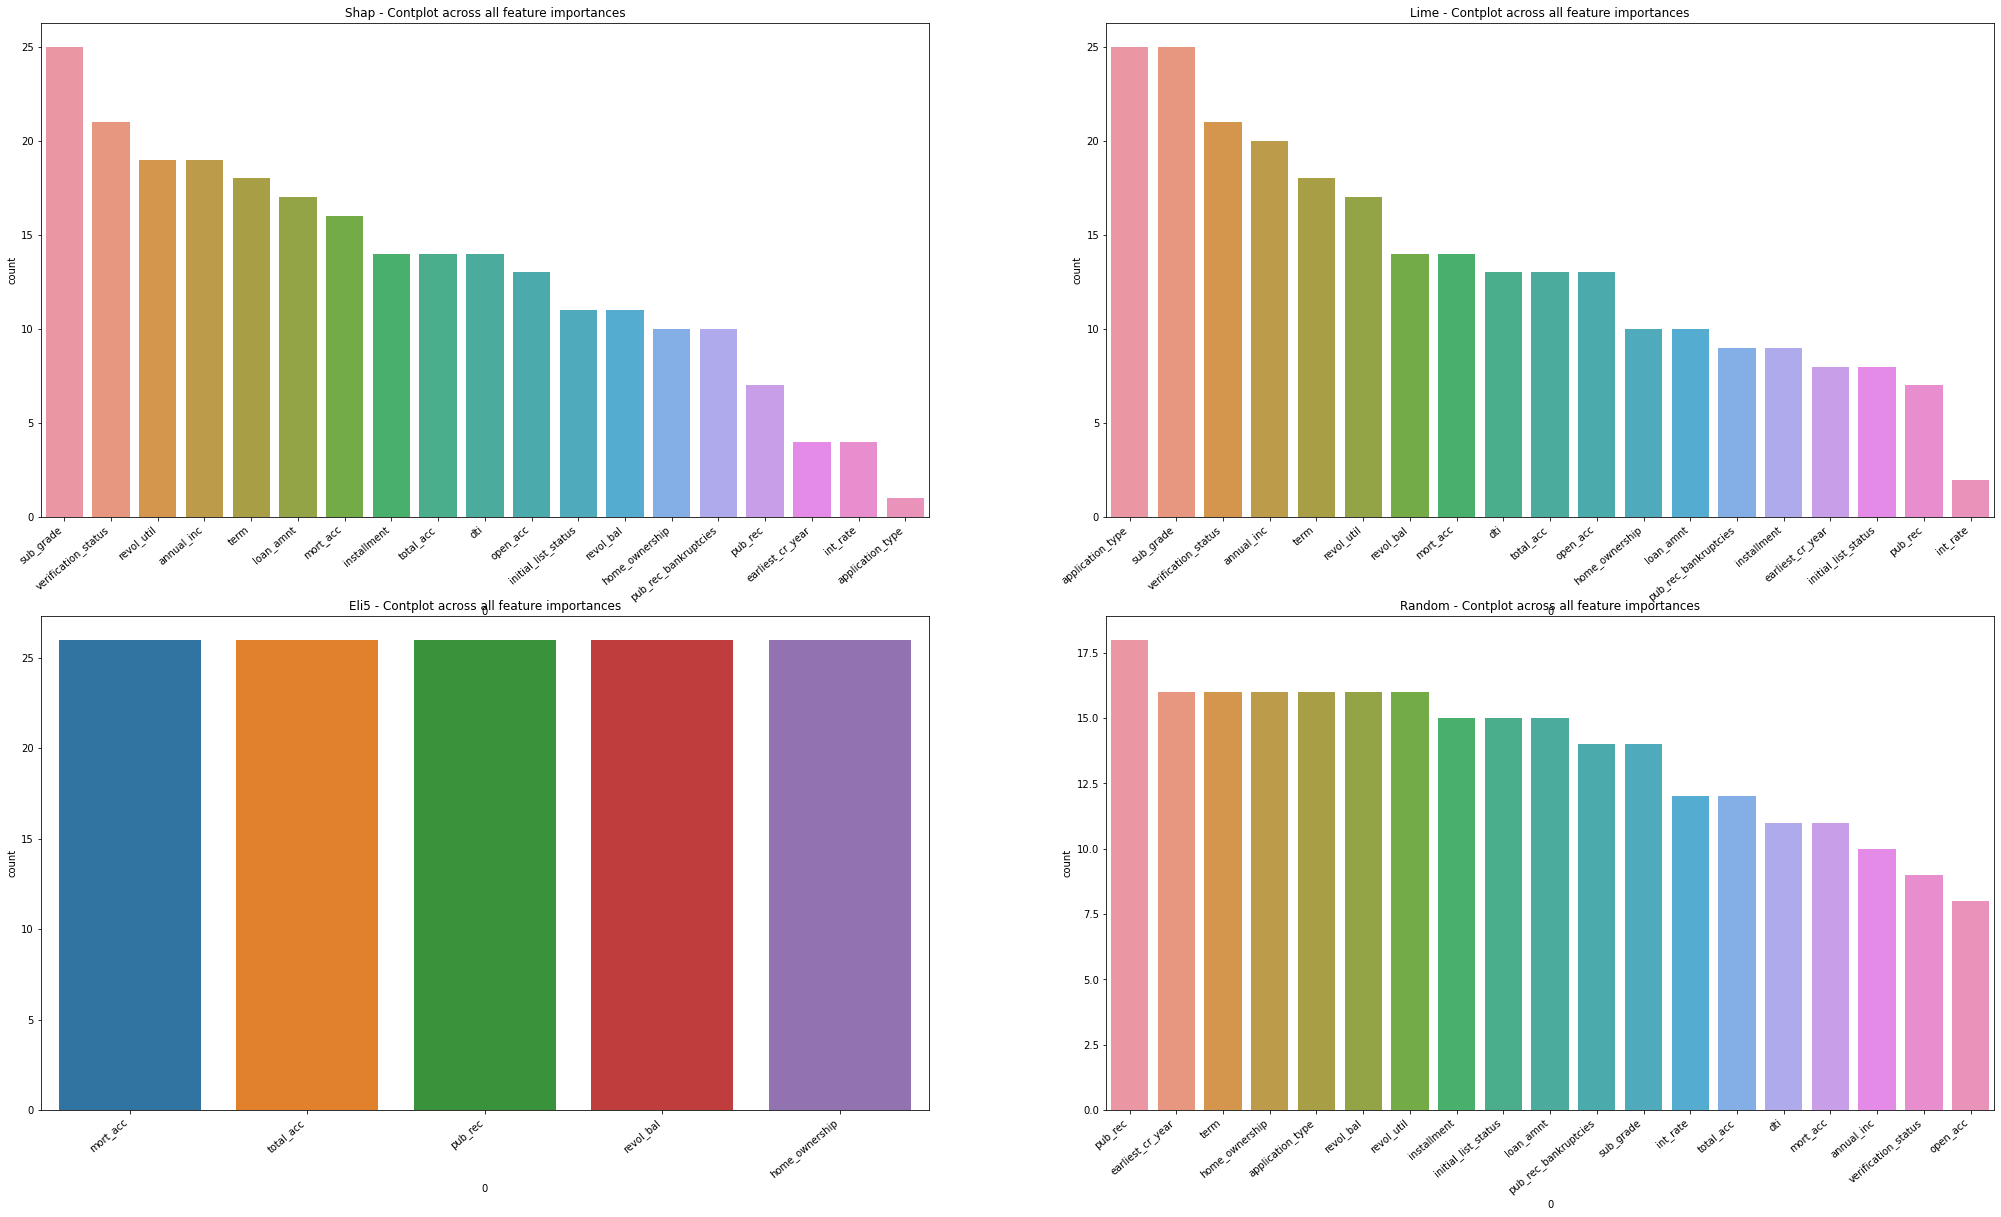

<Figure size 1800x288 with 0 Axes>

In [76]:
def get_countplot(explainer, feature_rankings="first"):
    columns = df.drop('loan_repaid', axis=1).columns
    result = res[(res['nsamples'] == 'auto') & (res['explainer'] == explainer) & (res["feature_rankings"] == feature_rankings) & 
                 (res["original_class"] == 0) & 
                 (res['strategy'] == 'distribution') & (res["no_features"]==10)].drop(['original_probability',"new_probability", "confidence_diff", "original_class", "class_change","no_features","nsamples","explainer","time","feature_rankings", "strategy"],axis=1)
    result.columns = [''] * len(result.columns)
#     result = result.dropna()
    flat_list = pd.DataFrame([columns[int(item)] for sublist in result.values.tolist() for item in sublist if not pd.isnull(item)])
    return flat_list

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(35, 20))
reverse_order = "first"
plt.figure(figsize=(25,4))

countplot_list = get_countplot("shap", "first")
# print(countplot_list)
ax[0][0] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[0][0])
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=40, ha="right")
ax[0][0].set_title("Shap - Contplot across all feature importances")

countplot_list = get_countplot("lime")
ax[0][1] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[0][1])
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), rotation=40, ha="right")
ax[0][1].set_title("Lime - Contplot across all feature importances")

countplot_list = get_countplot("eli5")
ax[1][0] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[1][0])
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=40, ha="right")
ax[1][0].set_title("Eli5 - Contplot across all feature importances")

countplot_list = get_countplot("random")
ax[1][1] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[1][1])
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), rotation=40, ha="right")
ax[1][1].set_title("Random - Contplot across all feature importances")

In [ ]:
emp_co = df[df['original_class']=="1"].groupby("emp_length").count()['loan_status']

emp_fp = df[df['loan_status']=="Fully Paid"].groupby("emp_length").count()['loan_status']


emp_len = emp_co/emp_fp

emp_len
emp_len.plot(kind='bar')

In [49]:
pd.options.display.max_columns = None
res

,original_probability,new_probability,confidence_diff,original_class,class_change,no_features,nsamples,explainer,time,feature_rankings,strategy,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10
0,0.531096,0.531096,0.000000e+00,1,False,0,100,shap,2.794693,first,mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.531096,0.531096,5.960464e-08,1,False,0,100,shap,0.616999,first,distribution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.531096,0.531096,0.000000e+00,1,False,0,100,shap,0.153088,middle,mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.531096,0.531096,5.960464e-08,1,False,0,100,shap,0.607831,middle,distribution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.531096,0.531096,0.000000e+00,1,False,0,100,shap,0.158313,last,mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107707,0.692507,0.730657,-3.814942e-02,1,False,9,auto,random,2.789584,middle,distribution_others,7.0,10.0,4.0,14.0,5.0,2.0,18.0,1.0,3.0,NaN,NaN
107708,0.692507,0.574869,1.176388e-01,1,False,9,auto,random,2.925323,last,distribution_others,2.0,18.0,1.0,3.0,9.0,11.0,8.0,0.0,16.0,NaN,NaN
107709,0.692507,0.627073,6.543457e-02,1,False,10,auto,random,2.807856,first,distribution_others,13.0,12.0,6.0,17.0,15.0,7.0,10.0,4.0,14.0,5.0,NaN
107710,0.692507,0.688427,4.080653e-03,1,False,10,auto,random,3.111922,middle,distribution_others,15.0,7.0,10.0,4.0,14.0,5.0,2.0,18.0,1.0,3.0,NaN


Text(0.5, 1.0, 'Random')

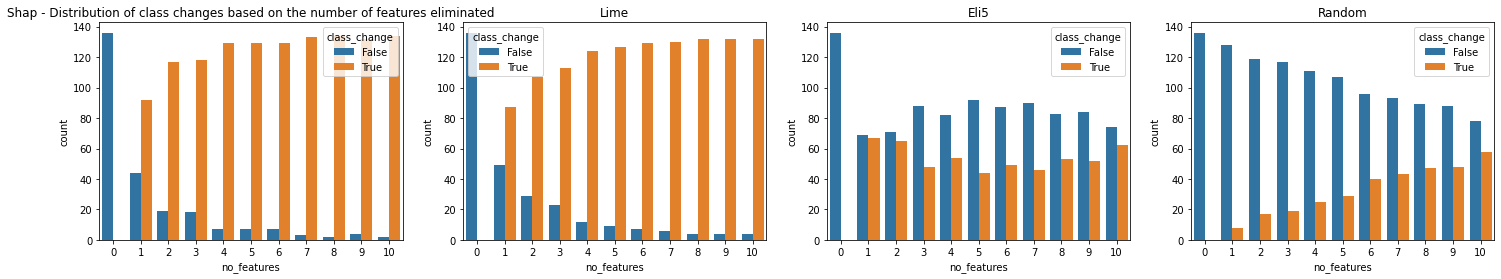

In [82]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(25, 4))

data = res[(res['nsamples'] == 'auto') &  (res["feature_rankings"] == "first") & (res['strategy'] == 'distribution')]

ax[0]=sns.countplot(x="no_features",data=data[data['explainer'] == 'shap'], hue = 'class_change', ax = ax[0])
ax[0].set_title("Shap - Distribution of class changes based on the number of features eliminated")

ax[1]=sns.countplot(x="no_features",data=data[data['explainer'] == 'lime'], hue = 'class_change', ax = ax[1])
ax[1].set_title("Lime")

ax[2]=sns.countplot(x="no_features",data=data[data['explainer'] == 'eli5'], hue = 'class_change', ax = ax[2])
ax[2].set_title("Eli5")

ax[3]=sns.countplot(x="no_features",data=data[data['explainer'] == 'random'], hue = 'class_change', ax = ax[3])
ax[3].set_title("Random")

In [18]:
res[(res['nsamples'] == 'auto')]

,original_probability,new_probability,confidence_diff,original_class,class_change,no_features,nsamples,explainer,time,feature_rankings,...,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10
17952,0.531096,0.531096,0.000000e+00,1,False,0,auto,shap,70.219228,first,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17953,0.531096,0.531096,5.960464e-08,1,False,0,auto,shap,0.912560,first,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17954,0.531096,0.531096,0.000000e+00,1,False,0,auto,shap,0.249331,middle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17955,0.531096,0.531096,5.960464e-08,1,False,0,auto,shap,0.968433,middle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17956,0.531096,0.531096,0.000000e+00,1,False,0,auto,shap,0.251363,last,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107707,0.692507,0.730657,-3.814942e-02,1,False,9,auto,random,2.789584,middle,...,10.0,4.0,14.0,5.0,2.0,18.0,1.0,3.0,NaN,NaN
107708,0.692507,0.574869,1.176388e-01,1,False,9,auto,random,2.925323,last,...,18.0,1.0,3.0,9.0,11.0,8.0,0.0,16.0,NaN,NaN
107709,0.692507,0.627073,6.543457e-02,1,False,10,auto,random,2.807856,first,...,12.0,6.0,17.0,15.0,7.0,10.0,4.0,14.0,5.0,NaN
107710,0.692507,0.688427,4.080653e-03,1,False,10,auto,random,3.111922,middle,...,7.0,10.0,4.0,14.0,5.0,2.0,18.0,1.0,3.0,NaN


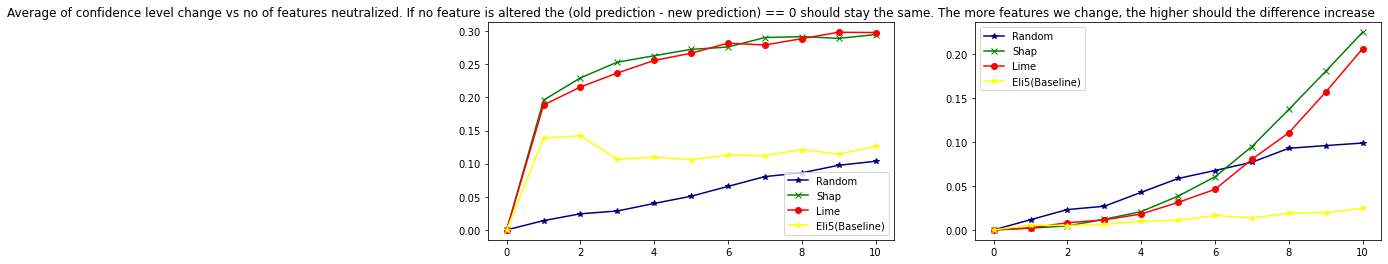

In [84]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

def get_data(explainer, feature_rankings ):
    data = res[(res['nsamples'] == 'auto') &  (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')]
    return data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].mean()

feature_rankings = "first"
no_of_features = list(range(0, len(get_data("random", "first")) ))
ax[0].plot( no_of_features,  get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random')
ax[0].plot( no_of_features, get_data("shap", feature_rankings) , color='green', marker='x', linestyle='-', label='Shap')
ax[0].plot( no_of_features, get_data("lime", feature_rankings) , color='red', marker='o', linestyle='-', label='Lime')
ax[0].plot( no_of_features, get_data("eli5", feature_rankings) , color='yellow', marker='*', linestyle='-', label='Eli5(Baseline)')
ax[0].set_title("Average of confidence level change vs no of features neutralized. If no feature is altered the (old prediction - new prediction) == 0 should stay the same. The more features we change, the higher should the difference increase")
ax[0].legend(loc='best')

feature_rankings = "last"
no_of_features = list(range(0, len(get_data("random", feature_rankings)) ))
ax[1].plot( no_of_features, get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random')
ax[1].plot( no_of_features, get_data("shap", feature_rankings), color='green', marker='x', linestyle='-', label='Shap')
ax[1].plot( no_of_features,get_data("lime", feature_rankings), color='red', marker='o', linestyle='-', label='Lime')
ax[1].plot( no_of_features, get_data("eli5", feature_rankings), color='yellow', marker='*', linestyle='-', label='Eli5(Baseline)')
# ax[1].set_title("Average of confidence level change vs no of features neutralized. If no feature is altered the (old prediction - new prediction) == 0 should stay the same. The more features we change, the higher should the difference increase")
ax[1].legend(loc='best')

In [20]:
res[(res['nsamples'] == 'auto') ].groupby("no_features")["confidence_diff"].mean() 

no_features
0     0.065631
1     0.086564
2     0.089970
3     0.090873
4     0.095993
5     0.099629
6     0.108134
7     0.111745
8     0.119448
9     0.123243
10    0.129119
Name: confidence_diff, dtype: float64

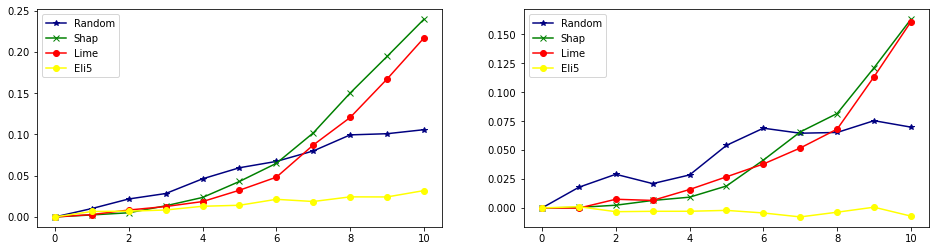

<Figure size 792x288 with 0 Axes>

<Figure size 792x288 with 0 Axes>

In [21]:
# Same as the graph above but the plot is class specific, in this case for class 1. For class 0, there are not enough datapoints to plot the graph
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

def get_data(explainer, feature_rankings ):
    data = res[(res['nsamples'] == 'auto') &  (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')]
    return data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].mean()

original_class = 1
avg_random = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'random') & (res['original_class'] == original_class) & (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')].groupby("no_features")["confidence_diff"].mean() 
avg_shap = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'shap') & (res['original_class'] == original_class) & (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')].groupby("no_features")["confidence_diff"].mean()
avg_lime = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'lime') & (res['original_class'] == original_class)  &(res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')].groupby("no_features")["confidence_diff"].mean()
avg_eli5 = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'eli5') & (res['original_class'] == original_class)  & (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')].groupby("no_features")["confidence_diff"].mean()

plt.figure(figsize=(11,4))
# plt.set_title('Training & Validation Loss')
no_of_features = list(range(0, len(avg_random) ))
ax[0].plot( no_of_features, avg_random, color='navy', marker='*', linestyle='-', label='Random')
ax[0].plot( no_of_features, avg_shap, color='green', marker='x', linestyle='-', label='Shap')
ax[0].plot( no_of_features, avg_lime, color='red', marker='o', linestyle='-', label='Lime')
ax[0].plot( no_of_features, avg_eli5, color='yellow', marker='o', linestyle='-', label='Eli5')
ax[0].legend(loc='best')

original_class = 0
avg_random = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'random') & (res['original_class'] == original_class) & (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')].groupby("no_features")["confidence_diff"].mean() 
avg_shap = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'shap') & (res['original_class'] == original_class) & (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')].groupby("no_features")["confidence_diff"].mean()
avg_lime = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'lime') & (res['original_class'] == original_class) & (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')].groupby("no_features")["confidence_diff"].mean()
avg_eli5 = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'eli5') & (res['original_class'] == original_class)  &(res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')].groupby("no_features")["confidence_diff"].mean()

plt.figure(figsize=(11,4))
# plt.set_title('Training & Validation Loss')
no_of_features = list(range(0, len(avg_random) ))
ax[1].plot( no_of_features, avg_random, color='navy', marker='*', linestyle='-', label='Random')
ax[1].plot( no_of_features, avg_shap, color='green', marker='x', linestyle='-', label='Shap')
ax[1].plot( no_of_features, avg_lime, color='red', marker='o', linestyle='-', label='Lime')
ax[1].plot( no_of_features, avg_eli5, color='yellow', marker='o', linestyle='-', label='Eli5')
ax[1].legend(loc='best')

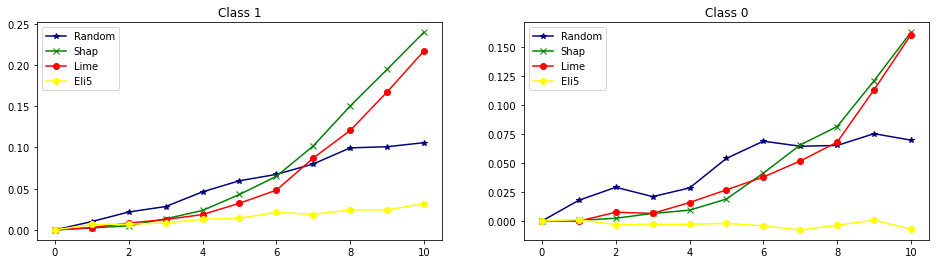

<Figure size 792x288 with 0 Axes>

<Figure size 792x288 with 0 Axes>

In [22]:
# Same as the graph above but the plot is class specific, in this case for class 1. For class 0, there are not enough datapoints to plot the graph
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

def get_data(explainer, original_class):
    default_data = res[(res['nsamples'] == 'auto') & (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')]
    return default_data[(default_data['explainer'] == explainer) & (default_data['original_class'] == original_class)].groupby("no_features")["confidence_diff"].mean()

original_class = 1
plt.figure(figsize=(11,4))
no_of_features = list(range(0, len(get_data("random", original_class)) ))
ax[0].plot( no_of_features, get_data("random", original_class), color='navy', marker='*', linestyle='-', label='Random')
ax[0].plot( no_of_features, get_data("shap", original_class), color='green', marker='x', linestyle='-', label='Shap')
ax[0].plot( no_of_features, get_data("lime", original_class), color='red', marker='o', linestyle='-', label='Lime')
ax[0].plot( no_of_features, get_data("eli5", original_class), color='yellow', marker='o', linestyle='-', label='Eli5')
ax[0].set_title("Class {}".format(original_class))
ax[0].legend(loc='best')

original_class = 0
plt.figure(figsize=(11,4))
no_of_features = list(range(0, len(avg_random) ))
ax[1].plot( no_of_features, get_data("random", original_class), color='navy', marker='*', linestyle='-', label='Random')
ax[1].plot( no_of_features, get_data("shap", original_class), color='green', marker='x', linestyle='-', label='Shap')
ax[1].plot( no_of_features, get_data("lime", original_class), color='red', marker='o', linestyle='-', label='Lime')
ax[1].plot( no_of_features, get_data("eli5", original_class), color='yellow', marker='o', linestyle='-', label='Eli5')
ax[1].set_title("Class {}".format(original_class))
ax[1].legend(loc='best')

In [23]:
res[res["original_class"] == 0].head(5)

,original_probability,new_probability,confidence_diff,original_class,class_change,no_features,nsamples,explainer,time,feature_rankings,...,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10
396,0.319999,0.319999,0.000000e+00,0,False,0,100,shap,2.765605,first,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
397,0.319999,0.319999,5.960464e-08,0,False,0,100,shap,0.611507,first,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
398,0.319999,0.319999,0.000000e+00,0,False,0,100,shap,0.165199,middle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399,0.319999,0.319999,5.960464e-08,0,False,0,100,shap,0.611070,middle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400,0.319999,0.319999,0.000000e+00,0,False,0,100,shap,0.159318,last,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


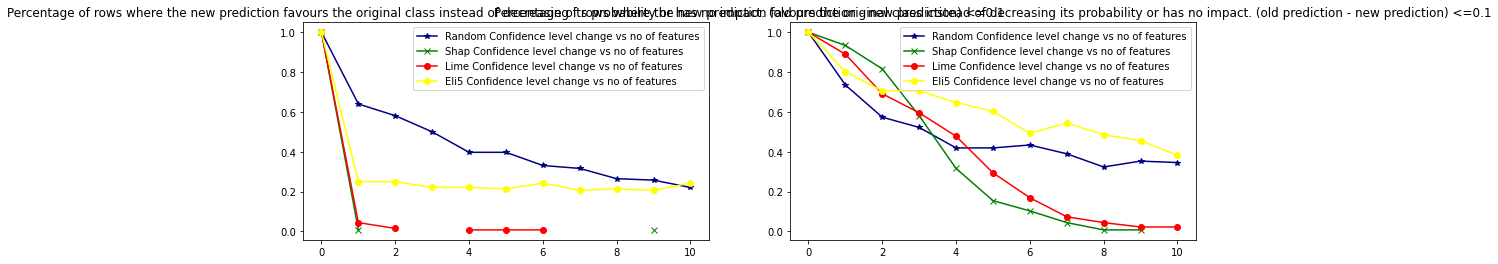

In [24]:
def get_data(explainer, feature_rankings):
    data = res[(res['nsamples'] == 'auto') & (res["feature_rankings"] == feature_rankings) & (res['strategy'] == 'distribution')] 
    data_count = data[(res['confidence_diff'] < 0.01)]
    return data_count[data_count['explainer'] == explainer].groupby("no_features")["confidence_diff"].count() / data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].count()

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

feature_rankings = "first"
no_of_features = list(range(0, len(get_data("random", feature_rankings)) ))
ax[0].plot( no_of_features, get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random Confidence level change vs no of features')
ax[0].plot( no_of_features, get_data("shap", feature_rankings), color='green', marker='x', linestyle='-', label='Shap Confidence level change vs no of features')
ax[0].plot( no_of_features, get_data("lime", feature_rankings), color='red', marker='o', linestyle='-', label='Lime Confidence level change vs no of features')
ax[0].plot( no_of_features, get_data("eli5", feature_rankings), color='yellow', marker='o', linestyle='-', label='Eli5 Confidence level change vs no of features')
ax[0].set_title("Percentage of rows where the new prediction favours the original class instead of decreasing its probability or has no impact. (old prediction - new prediction) <=0.1")
ax[0].legend(loc='best')

feature_rankings = "last"
no_of_features = list(range(0, len(get_data("random", feature_rankings)) ))
ax[1].plot( no_of_features, get_data("random", feature_rankings), color='navy', marker='*', linestyle='-', label='Random Confidence level change vs no of features')
ax[1].plot( no_of_features, get_data("shap", feature_rankings), color='green', marker='x', linestyle='-', label='Shap Confidence level change vs no of features')
ax[1].plot( no_of_features, get_data("lime", feature_rankings), color='red', marker='o', linestyle='-', label='Lime Confidence level change vs no of features')
ax[1].plot( no_of_features, get_data("eli5", feature_rankings), color='yellow', marker='o', linestyle='-', label='Eli5 Confidence level change vs no of features')
ax[1].set_title("Percentage of rows where the new prediction favours the original class instead of decreasing its probability or has no impact. (old prediction - new prediction) <=0.1")
ax[1].legend(loc='best')

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


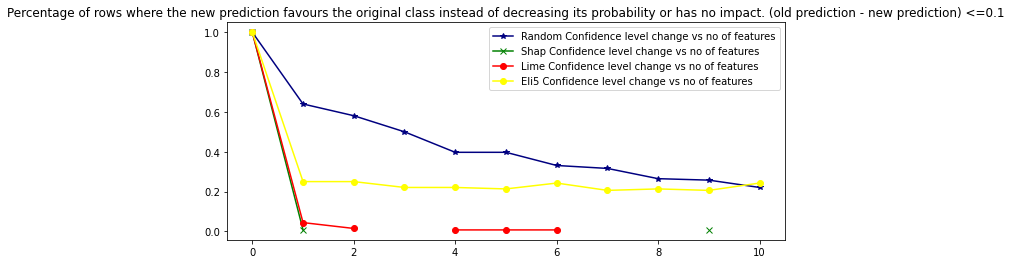

In [25]:
def get_data(explainer):
    data = res[(res['nsamples'] == 'auto')  & (res["feature_rankings"] == "first") & (res['strategy'] == 'distribution') ]
    data_count = data[(res['confidence_diff'] < 0.01)]
    return data_count[data_count['explainer'] == explainer].groupby("no_features")["confidence_diff"].count() / data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].count()

plt.figure(figsize=(10,4))
no_of_features = list(range(0, len(get_data("shap")) ))
plt.plot( no_of_features, get_data("random"), color='navy', marker='*', linestyle='-', label='Random Confidence level change vs no of features')
plt.plot( no_of_features, get_data("shap"), color='green', marker='x', linestyle='-', label='Shap Confidence level change vs no of features')
plt.plot( no_of_features, get_data("lime"), color='red', marker='o', linestyle='-', label='Lime Confidence level change vs no of features')
plt.plot( no_of_features, get_data("eli5"), color='yellow', marker='o', linestyle='-', label='Eli5 Confidence level change vs no of features')
plt.title("Percentage of rows where the new prediction favours the original class instead of decreasing its probability or has no impact. (old prediction - new prediction) <=0.1")
plt.legend(loc='best')

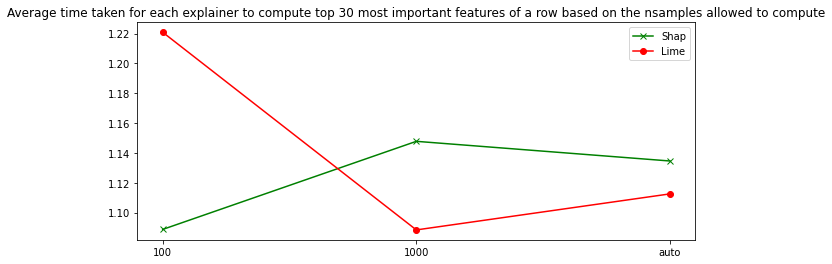

In [26]:
avg_shap = res[(res["no_features"]==10) & (res['explainer'] == 'shap')  & (res["feature_rankings"] == "first") & (res['strategy'] == 'distribution')].groupby("nsamples")["time"].mean()
avg_lime = res[(res["no_features"]==10) & (res['explainer'] == 'lime')  & (res["feature_rankings"] == "first") & (res['strategy'] == 'distribution')].groupby("nsamples")["time"].mean()

plt.figure(figsize=(10,4))
# plt.set_title('Training & Validation Loss')
no_of_features = list(range(0, len(avg_shap)))
# plt.plot( no_of_features, avg_random, color='navy', marker='*', linestyle='-', label='Random')
plt.plot( avg_lime.keys(), avg_shap, color='green', marker='x', linestyle='-', label='Shap')
plt.plot( avg_lime.keys(), avg_lime, color='red', marker='o', linestyle='-', label='Lime')
plt.title("Average time taken for each explainer to compute top 30 most important features of a row based on the nsamples allowed to compute")
plt.legend(loc='best')

In [27]:
avg_shap

nsamples
100     1.088768
1000    1.147782
auto    1.134606
Name: time, dtype: float64

In [28]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

def base_model():       
    return model
# X_train_unscaled, X_test_unscaled, y_train, y_test
# train_x, val_x, train_y, val_y
my_model = KerasRegressor(build_fn=base_model)    
my_model.fit(X_test, y_test)

perm = PermutationImportance(my_model).fit(X_test[0:1000],y_test[0:1000])
eli5.show_weights(perm, feature_names = list(df.drop('loan_repaid', axis=1).columns))

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


32/32 [==============================] - 0s 3ms/step - loss: 0.4478 - accuracy: 0.8070 - f1: 0.8907


Weight,Feature
0.0734 ± 0.0148,sub_grade
0.0037 ± 0.0018,open_acc
0.0031 ± 0.0018,term
0.0022 ± 0.0008,verification_status
0.0019 ± 0.0023,int_rate
0.0015 ± 0.0009,revol_util
0.0012 ± 0.0006,earliest_cr_year
0.0011 ± 0.0005,installment
0.0011 ± 0.0009,annual_inc
0.0010 ± 0.0007,dti


In [29]:
row_number=2
columns = list(df.drop('loan_repaid', axis=1).columns)
explainer_lime = lime_tabular.LimeTabularExplainer(X_train, class_names=list(['Charged off', 'Fully paid']), feature_names= list(df.drop('loan_repaid', axis=1).columns))
exp = explainer_lime.explain_instance(X_test[row_number], model.predict, num_features=30, top_labels=30)  
exp.show_in_notebook(show_table=True, show_all=False)
# model.predict()


                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


In [30]:
# eli5.show_prediction(model, X_test[row_number].reshape(1, X_test.shape[1]))

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


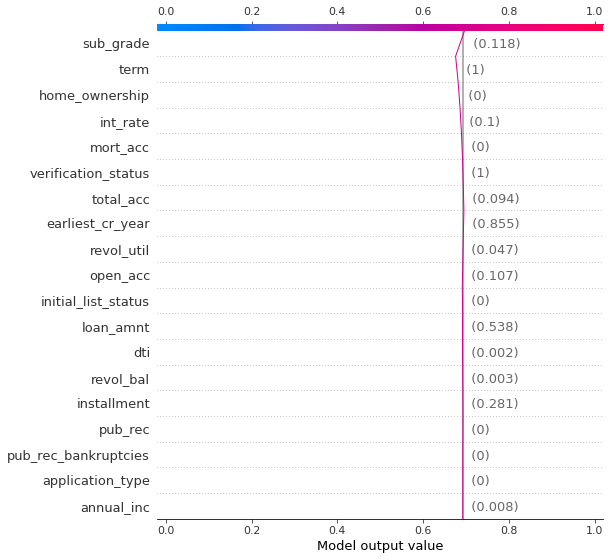

In [31]:
# https://slundberg.github.io/shap/notebooks/plots/decision_plot.html -- types of plots available for shap
import shap
def predict_fn(x):
    preds = model.predict(x).reshape(-1, 1)
    p0 = 1 - preds
    return np.hstack((p0, preds))
row_number=2
explainer_shap = shap.KernelExplainer(model.predict, X_train[0:1000])
shap_values = explainer_shap.shap_values(X_test[row_number].reshape(1, X_test.shape[1]), nsamples="auto", l1_reg="num_features(30)")

shap.decision_plot(explainer_shap.expected_value[0], shap_values[0][0, :], X_test[row_number], feature_names=list(df.drop('loan_repaid', axis=1).columns), link="logit")

In [32]:
shap.initjs()
shap.force_plot(explainer_shap.expected_value[0], shap_values[0][0, :], X_test[row_number], feature_names=list(df.drop('loan_repaid', axis=1).columns), link="logit")

In [33]:
df.drop('loan_repaid', axis=1).columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'earliest_cr_year'],
      dtype='object')

In [34]:
X_test[row_number]

array([0.53846154, 1.        , 0.10011687, 0.2807641 , 0.11764706,
       0.        , 0.00820069, 1.        , 0.00212921, 0.10666667,
       0.        , 0.00298979, 0.04673316, 0.09395973, 0.        ,
       0.        , 0.        , 0.        , 0.85507246])

In [35]:
# %tensorboard --logdir "logs\\hparam_tuning\\2020-07-04-2313" --host localhost --port 8080

In [36]:
explainer_shap.expected_value

array([0.81055206])

In [37]:
class_avg_1 = [a for a in y_test if a  ==1]
sum(class_avg_1)/len(y_train)
# class_avg_1
model.predict(X_test[row_number].reshape(1, X_test.shape[1]))

array([[0.8301842]], dtype=float32)

In [40]:
global_shap_values = explainer_shap.shap_values(X_test[0:10])
shap.summary_plot(global_shap_values, X_test[0:10])

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

KeyboardInterrupt: 

In [ ]:
help(shap.summary_plot)

In [ ]:
shap.summary_plot(global_shap_values, X_test[0:10], plot_type="bar", feature_names=list(df.drop('loan_repaid', axis=1).columns))

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir "ray_res/" 

In [ ]:
import os
path="/home/dan393/ray_results_f/create_model_tune_cofig"
os.chdir(path)
for file in os.listdir():
    if os.path.isdir(file):
        split_words = file.split("_")
        os.rename(file, "create_model_tune_cofig_{}_{}".format(split_words[4], split_words[len(split_words)-1]))

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir "ray_res/" 

In [ ]:
import os
path="/home/dan393/ray_results_f/create_model_tune_cofig"
os.chdir(path)
for file in os.listdir():
    if os.path.isdir(file):
        split_words = file.split("_")
        os.rename(file, "create_model_tune_cofig_{}_{}".format(split_words[4], split_words[len(split_words)-1]))